## Import your stuff

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import pydelfi.score as score

tfd = tfp.distributions
tfb = tfp.bijectors

%matplotlib inline

In [2]:
import scipy.integrate as integrate
import simulators.jla_supernovae.jla_parser as jla_parser

class JLA_Model():

    def __init__(self, jla_data_path = 'simulators/jla_supernovae/jla_data/'):

        # Import data
        jla_data, jla_cmats = jla_parser.b14_parse(z_min=None, z_max=None, qual_cut=False,
                                           jla_path='simulators/jla_supernovae/jla_data/')
        self.data = jla_data['mb']
        delta_m_cut = 10
        self.auxiliary_data = np.column_stack([jla_data['zcmb'], jla_data['x1'], jla_data['color'], np.array([(jla_data['3rdvar'] > delta_m_cut)], dtype=int)[0]])

        # Om, w0, M_b, alpha, beta, delta_m
        self.npar = 2
        self.theta_fiducial = np.array([  0.20181324,  -0.74762939, -19.04253368,   0.12566322,   2.64387045, -0.05252869])

        # Covariance matrix
        self.C = jla_parser.b14_covariance(jla_data, jla_cmats, self.theta_fiducial[3], self.theta_fiducial[4])
        self.Cinv = np.linalg.inv(self.C)
        self.L = np.linalg.cholesky(self.C)

        # Derivative of the covariance matrix
        self.n_sn = len(self.C)
        self.dCdt = np.zeros((self.npar, self.n_sn, self.n_sn))

        # N data points
        self.ndata = len(jla_data['mb'])

        # Compute the mean
        self.mu = self.apparent_magnitude(self.theta_fiducial)

    # Distance modulus
    def apparent_magnitude(self, theta):
        
        # Cosmological parameters
        Om = theta[0]
        w0 = theta[1]
        h = 0.7
        
        # Systematics parameters
        Mb = -19.05
        alpha = 0.125
        beta = 2.65
        delta_m = -0.05
        
        # Pull out the relevant things from the data
        z = self.auxiliary_data[:,0]
        x = self.auxiliary_data[:,1]
        c = self.auxiliary_data[:,2]
        v3 = self.auxiliary_data[:,3]
        
        # Holders
        distance_modulus = np.zeros(len(z))
        
        for i in range(len(z)):
            integral = integrate.quad(lambda zz: 1./np.sqrt( Om*(1+zz)**3 + (1-Om)*(1+zz)**(3*(1+w0)) ), 0, z[i])[0]
            distance_modulus[i] = 25 - 5*np.log10(h) + 5*np.log10(3000*(1+z[i])*integral)
        
        return Mb - alpha*x + beta*c + delta_m*v3 + distance_modulus

    # Generate realisation of \mu
    def simulation(self, theta, seed):
        
        # Set the seed
        np.random.seed(seed)

        # Signal
        mb = self.apparent_magnitude(theta)
        
        # Noise
        noise = np.dot(self.L, np.random.normal(0, 1, len(self.L)))
        
        # Return signal + noise
        return mb + noise

    # Generate derivative of \mu w.r.t cosmological parameters
    def dmudt(self, theta_fiducial, h):
        
        # dmdt
        dmdt = np.zeros((self.npar, self.ndata))
        
        # Fiducial data
        d_fiducial = self.apparent_magnitude(theta_fiducial)
        
        # Loop over parameters
        for i in range(0, 2):
            
            # Step theta
            theta = np.copy(self.theta_fiducial)
            theta[i] += h[i]
            
            # Shifted data with same seed
            d_dash = self.apparent_magnitude(theta)
            
            # One step derivative
            dmdt[i,:] = (d_dash - d_fiducial)/h[i]
        
        #dmdt[2,:] = np.ones(self.n_sn)
        #dmdt[3,:] = -self.auxiliary_data[:,1]
        #dmdt[4,:] = self.auxiliary_data[:,2]
        #dmdt[5,:] = self.auxiliary_data[:,3]
        
        return dmdt

In [3]:
# we define a few hyper parameters here
np.random.seed(13)
n = 2000 # total number of data points for NF
n_sims = 2500  # total number of points for drawing posterior

## Set up the simulator

In [4]:
JLASimulator = JLA_Model()

def simulator(theta, batch, seed=None, simulator_args=None):
    if seed is not None:
        arr = []
        for index in range(batch):
            arr.append(JLASimulator.simulation(theta, seed))
        return np.array(arr)
    else:
        arr = []
        for index in range(batch):
            arr.append(JLASimulator.simulation(theta, index))
        return np.array(arr)

simulator_args = None

C:\Users\Davide\Downloads\pydelfi\examples\simulators\jla_supernovae\jla_parser.py:9: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype = None, names = True)


## Set up the prior

In [5]:
# we are going to work only with two parameters
lower = np.array([0.0, -1.5, -19.05, 0.125, 2.65, -0.05])
upper = np.array([0.6, 0, -19.05, 0.125, 2.65, -0.05])

## Set up the compressor
Must have the signature `compressor(data, args)` -> `np.array([n_summaries])`<br>
In this case we are going to do Gaussian score compression $$\mathbf{t} = \boldsymbol\theta_* + \mathbf{F}^{-1}\nabla_\theta^T\boldsymbol\mu_*\mathbf{C}^{-1}(\mathbf{d}-\boldsymbol\mu_*)$$ using the class `score.Gaussian`. For this we'll need some fiducial parameters, the mean its derivative at the fiducial parameters, the inverse covariance, and the inverse Fisher matrix

In [6]:
theta_fiducial = np.array([0.2, -0.75])#, -19.05, 0.125, 2.65, -0.05])

mu = JLASimulator.apparent_magnitude(theta_fiducial)
Cinv = JLASimulator.Cinv

h = np.array(abs(theta_fiducial[:2]))*0.01  # only use the first two parameters
dmudt = JLASimulator.dmudt(theta_fiducial, h)

Compressor = score.Gaussian(len(JLASimulator.data), theta_fiducial, mu = mu, Cinv = Cinv, dmudt = dmudt)
Compressor.compute_fisher()
Finv = Compressor.Finv

def compressor(d, compressor_args=None):
    return Compressor.scoreMLE(d)
compressor_args=None

In [7]:
mu.shape

(740,)

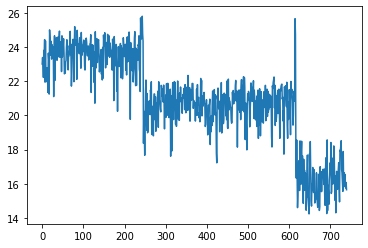

In [8]:
plt.plot(np.arange(740), mu)

## Load in the compressed data

In [9]:
data_fiducial = simulator(theta_fiducial, n)
print(data_fiducial.shape)

(2000, 740)


In [10]:
summaries_noise = []
for index in range(n):
    summaries_noise.append(compressor(data_fiducial[index]))
summaries_noise = np.asarray(summaries_noise)

0.11432201769143664
0.263472365812343


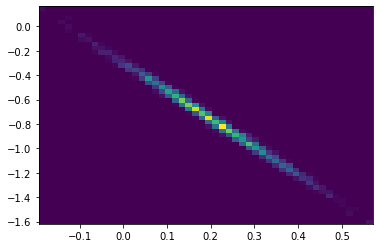

In [11]:
# first we plot the distribution of the noisy summaries
bins = 50
plt.hist2d(summaries_noise[:, 0], summaries_noise[:, 1], bins=bins);
print(summaries_noise[:, 0].std())
print(summaries_noise[:, 1].std())

In [12]:
data_fixed_noise = np.zeros((n_sims, 740))
n_bins = 50
xx = np.linspace(0, 0.6, n_bins, endpoint=True)
yy = np.linspace(-1.5, 0, n_bins, endpoint=True)
index = 0
q_prior = np.zeros((n_bins*n_bins, 2))
for i in xx:
    for j in yy:
        theta = [i, j]
        data_fixed_noise[index] = simulator(theta, 1, seed=0)
        q_prior[index, :] = i, j
        index += 1

(2500, 740)

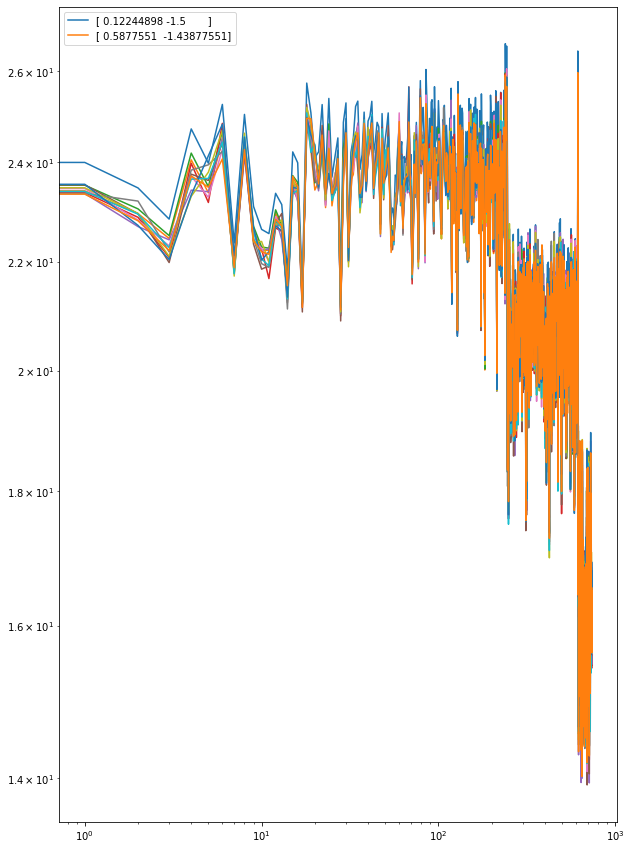

In [13]:
plt.figure(figsize=(10, 15))
for index in [500, 2402]:
    plt.loglog(np.arange(740), data_fixed_noise[index], label=q_prior[index])
for index in range(10):
    plt.loglog(np.arange(740), data_fiducial[index])
#plt.loglog(np.arange(n_vec), d_vec_obs[0], label='Observation', linestyle = '--')
plt.legend();
data_fixed_noise.shape

In [14]:
summaries_posterior = []
for index in range(n_sims):
    summaries_posterior.append(compressor(data_fixed_noise[index]))  # it should be in the whole prior 
summaries_posterior = np.asarray(summaries_posterior)

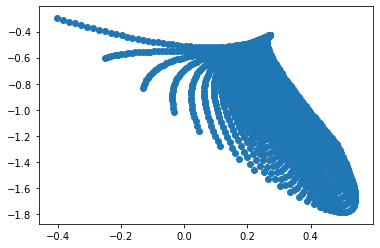

In [15]:
plt.scatter(summaries_posterior[:, 0], summaries_posterior[:, 1]);

In [16]:
# we also create the data corresponding to fixed noise, at the fiducial q
data_fiducial_shift = simulator(theta_fiducial, 1, seed=0)

In [17]:
summary_shift = compressor(data_fiducial_shift[0]) 
summary_shift = np.reshape(summary_shift, [1, -1])

In [18]:
data_obs = simulator(theta_fiducial, 1, 1)

In [19]:
summary_obs = compressor(data_obs[0])
summary_obs = np.reshape(summary_obs, [1, -1])

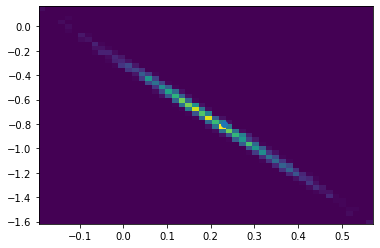

In [20]:
bins = 50
plt.hist2d(summaries_noise[:, 0], summaries_noise[:, 1], bins=bins);
plt.scatter(summary_obs[0, 0], summary_obs[0, 1]);

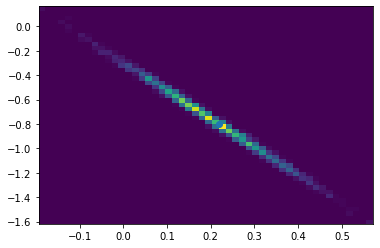

In [21]:
# we also check if the shift FN is within the summaries of the fiducial noisy data
bins = 50
plt.hist2d(summaries_noise[:, 0], summaries_noise[:, 1], bins=bins);
plt.scatter(summary_shift[0][0], summary_shift[0][1])

# Gaussianisation of the latent space

At this stage, we finally need to set up the NF between the obtaines sample of summaries, in order to have the bijection to that space. We will use Inverse Autoregressive Flows (IAFs).

In [22]:
# we define a few variables here, and reset the graph
DTYPE=tf.float32
NP_DTYPE=np.float32
tf.reset_default_graph()
batch_size = 128
num_bijectors = 16

# we transform the summaries to a TF dataset object
dataset = tf.data.Dataset.from_tensor_slices(summaries_noise.astype(NP_DTYPE))
dataset = dataset.repeat()
dataset = dataset.shuffle(buffer_size=summaries_noise.shape[0])
dataset = dataset.prefetch(3 * batch_size)
dataset = dataset.batch(batch_size)
data_iterator = dataset.make_one_shot_iterator()
x_samples = data_iterator.get_next()

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [23]:
# this is the distribution to match
#base_dist = tfd.Normal(loc=0.0, scale=1.0)
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], DTYPE))

In [24]:
# we define the flow here
bijectors = []
for i in range(num_bijectors):
    bijectors.append(tfb.Invert(tfb.MaskedAutoregressiveFlow(
            shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(
                hidden_layers=[1024, 1024]))))
    bijectors.append(tfb.Permute(permutation=[1, 0]))
# discard the last Permute layer.
flow_bijector = tfb.Chain(list(reversed(bijectors[:-1])))

In [25]:
# this is the transformed distribution, i.e. the distribution of the summaries
dist = tfd.TransformedDistribution(
            distribution=base_dist,
            bijector=flow_bijector)

In [26]:
# optimisation
loss = -tf.reduce_mean(dist.log_prob(x_samples))
train_op = tf.train.AdamOptimizer(1e-3).minimize(loss)

Instructions for updating:
Please use `layer.__call__` method instead.


0 2.209251
500 -3.156402
1000 -2.9554756
1500 -3.1534557


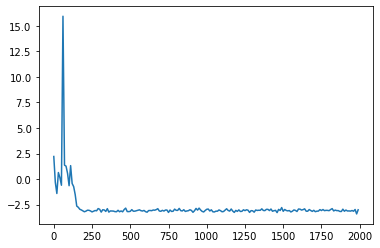

In [27]:
# and finally we train the NF as well
sess = tf.Session()
sess.run(tf.global_variables_initializer())
NUM_STEPS = 2000#int(settings[TARGET_DENSITY]['train_iters'])
global_step = []
losses = []
for i in range(NUM_STEPS):
    _, np_loss = sess.run([train_op, loss])
    if i % 10 == 0:
        global_step.append(i)
        losses.append(np_loss)
        #g_losses.append(gl)
    if i % int(5e2) == 0:
        print(i, np_loss)
start = 0
plt.plot(global_step, losses[start:])

In [28]:
# now we need to look at samples which we inject in the flow to the Gaussian domain
# just to make sure the gaussianisation was successful

In [33]:
# we look at the flow injection, which corresponds to the inverse pass
x = x_samples
samples = [x]
names = [base_dist.name]
for bijector in dist.bijector.bijectors:
    x = bijector.inverse(x)
    samples.append(x)
    names.append(bijector.name)
samples_plot = [samples[0], samples[-1], base_dist.sample(128)]
names=['Latent', 'Mapped latent', 'Original Gaussian']

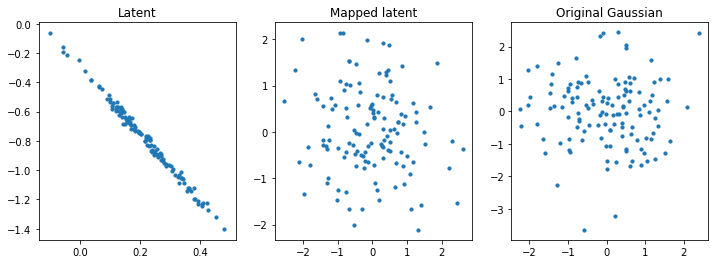

In [34]:
noise_flow = sess.run(samples_plot)
f, arr = plt.subplots(1, len(noise_flow), figsize=(4 * (len(noise_flow)), 4))
X0 = noise_flow[0]
for i in range(len(noise_flow)):
    X1 = noise_flow[i]
    arr[i].scatter(X1[:, 0], X1[:, 1], s=10)
    arr[i].set_title(names[i])

In [35]:
print(noise_flow[0][:, 0].mean())
print(noise_flow[0][:, 1].mean())
print(noise_flow[1][:, 0].mean())
print(noise_flow[1][:, 1].mean())
print(noise_flow[2][:, 0].mean())
print(noise_flow[2][:, 1].mean())

0.2145977
-0.78570247
-0.060631793
0.03711669
-0.019231008
-0.010123998


In [36]:
print(noise_flow[0][:, 0].std())
print(noise_flow[0][:, 1].std())
print(noise_flow[1][:, 0].std())
print(noise_flow[1][:, 1].std())
print(noise_flow[2][:, 0].std())
print(noise_flow[2][:, 1].std())

0.11178331
0.25726548
1.0055177
0.9243995
0.97185796
1.0405332


In [37]:
# we need to inject all of the summaries
# in order to do that, we create many Dataset objects
# we need to transform the the FN vectors, the observation, and the posterior points
dataset = tf.data.Dataset.from_tensor_slices(summary_obs.astype(NP_DTYPE))
dataset = dataset.repeat()
dataset = dataset.prefetch(3 * 1)
dataset = dataset.batch(1)
data_iterator = dataset.make_one_shot_iterator()
x_samples_obs = data_iterator.get_next()

In [38]:
# we need to inject all of the summaries
# in order to do that, we create many Dataset objects
# we need to transform the the FN vectors, the observation, and the posterior points
dataset = tf.data.Dataset.from_tensor_slices(summaries_posterior.astype(NP_DTYPE))
dataset = dataset.repeat()
dataset = dataset.prefetch(3 * n_sims)
dataset = dataset.batch(n_sims)
data_iterator = dataset.make_one_shot_iterator()
x_samples_posterior = data_iterator.get_next()

In [39]:
# we inject the shift as well
dataset = tf.data.Dataset.from_tensor_slices(summary_shift.astype(NP_DTYPE))
dataset = dataset.repeat()
dataset = dataset.prefetch(3 * 1)
dataset = dataset.batch(1)
data_iterator = dataset.make_one_shot_iterator()
x_samples_shift = data_iterator.get_next()

In [40]:
# we inject the FN observation in the flow, since we need the fiducial one for the posterior evaluation
x = x_samples_shift
samples = [x]
for bijector in dist.bijector.bijectors:
    x = bijector.inverse(x)
    samples.append(x)
shift_flow_ = samples[-1]
shift = sess.run(shift_flow_)

In [41]:
shift[0]

array([-0.14727774,  0.19376792], dtype=float32)

In [42]:
# we inject the posterior points
x = x_samples_posterior
samples = [x]
for bijector in dist.bijector.bijectors:
    x = bijector.inverse(x)
    samples.append(x)
posterior_points_ = samples[-1]
posterior_points = sess.run(posterior_points_)

In [43]:
# check that there are no duplicates
posterior_points__ = list(np.reshape(posterior_points, [-1]))

import collections
print ([item for item, count in collections.Counter(posterior_points__).items() if count > 1])

[4.5298715, 28.842548]


In [44]:
# we need to shift the posterior points as we want the mean to be captured, and they have fixed noise
posterior_points_mu = posterior_points - shift[0]

In [45]:
# finally, we try to evaluate the posterior
# we first inject the observation in the flow as well
x = x_samples_obs
samples = [x]
for bijector in dist.bijector.bijectors:
    x = bijector.inverse(x)
    samples.append(x)
observation_ = samples[-1]
compressed_obs = sess.run(observation_)

In [46]:
posterior_points.shape

(2500, 2)

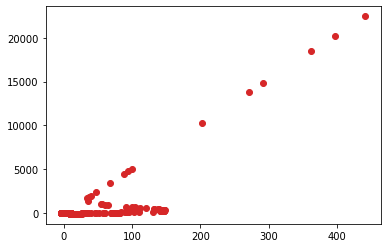

In [47]:
plt.scatter(noise_flow[1][:, 0], noise_flow[1][:, 1])
plt.scatter(compressed_obs[0][0], compressed_obs[0][1])
plt.scatter(shift[0][0], shift[0][1]);
plt.scatter(posterior_points_mu[:, 0], posterior_points_mu[:, 1]);

In [48]:
# finally we evaluate the likelihood
from scipy.stats import multivariate_normal as normal
likelihood_arr = np.zeros((n_sims, 3))
for index, mu in enumerate(posterior_points_mu):
    like_value = normal.pdf(compressed_obs[0], mean=mu, cov=np.eye(2))
    likelihood_arr[index, :] = q_prior[index, 0], q_prior[index, 1], like_value

In [49]:
likelihood_arr[:, 2] = likelihood_arr[:, 2]/likelihood_arr[:, 2].sum()

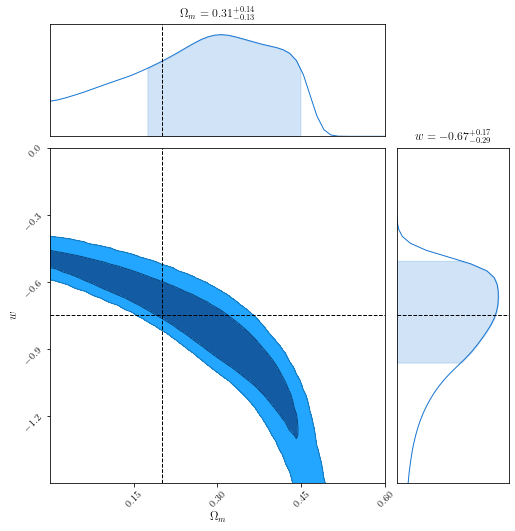

In [52]:
# now we loo for the comparison with pydelfi, 
# which in this case acts as the "ground truth"

In [53]:
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import pydelfi.score as score
import pydelfi.priors as priors
tf.logging.set_verbosity(tf.logging.ERROR)

In [54]:
JLASimulator = JLA_Model()

def simulator(theta, seed, simulator_args, batch):
    
    return JLASimulator.simulation(theta, seed)

simulator_args = None

C:\Users\Davide\Downloads\pydelfi\examples\simulators\jla_supernovae\jla_parser.py:9: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype = None, names = True)


In [55]:
# we are going to work only with two parameters
lower = np.array([0.0, -1.5])#, -19.05, 0.125, 2.65, -0.05])
upper = np.array([0.6, 0])#, -19.05, 0.125, 2.65, -0.05])
prior = priors.Uniform(lower, upper)

In [56]:
theta_fiducial = np.array([0.2, -0.75])#, -19.05, 0.125, 2.65, -0.05])

mu = JLASimulator.apparent_magnitude(theta_fiducial)
Cinv = JLASimulator.Cinv

h = np.array(abs(theta_fiducial))*0.01
dmudt = JLASimulator.dmudt(theta_fiducial, h)

Compressor = score.Gaussian(len(JLASimulator.data), theta_fiducial, mu = mu, Cinv = Cinv, dmudt = dmudt)
Compressor.compute_fisher()
Finv = Compressor.Finv

def compressor(d, compressor_args):
    return Compressor.scoreMLE(d)
compressor_args=None

In [57]:
compressed_data = compressor(JLASimulator.data, compressor_args)

In [58]:
NDEs = [ndes.MixtureDensityNetwork(n_parameters=2, n_data=2, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=0),
       ndes.MixtureDensityNetwork(n_parameters=2, n_data=2, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
       ndes.MixtureDensityNetwork(n_parameters=2, n_data=2, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
       ndes.MixtureDensityNetwork(n_parameters=2, n_data=2, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
       ndes.MixtureDensityNetwork(n_parameters=2, n_data=2, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
       ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=2, n_data=2, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=5)]

In [59]:
DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs, 
                            Finv = Finv, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\\Omega_m', 'w_0'], 
                            results_dir = "simulators/jla_supernovae/results/",
                            input_normalization="fisher")

Sampling approximate posterior...
Done.
Removed no burn in


C:\Users\Davide\Anaconda3\lib\site-packages\pydelfi-0.1-py3.6.egg\pydelfi\delfi.py:626: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
C:\Users\Davide\Anaconda3\lib\site-packages\pydelfi-0.1-py3.6.egg\pydelfi\delfi.py:632: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


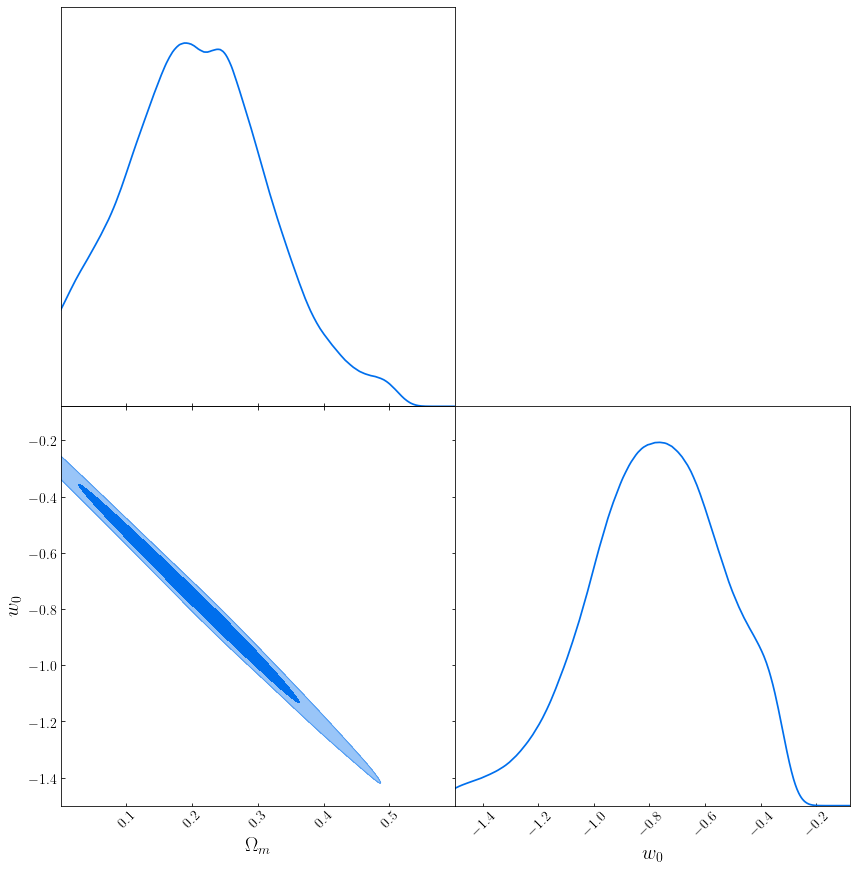

In [60]:
DelfiEnsemble.fisher_pretraining()

In [ ]:
n_initial = 200
n_batch = 200
n_populations = 10

# how many data points are we using?!
# apparently, n_initial+n_batch*n_populations = 2200 in this case?

DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20,
                       save_intermediate_posteriors=False)

Population 1/10
Sampling proposal density...
Done.


C:\Users\Davide\Anaconda3\lib\site-packages\pydelfi-0.1-py3.6.egg\pydelfi\delfi.py:667: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.


Population 2/10
Sampling proposal density...
Done.


C:\Users\Davide\Anaconda3\lib\site-packages\pydelfi-0.1-py3.6.egg\pydelfi\delfi.py:667: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.


Population 3/10
Sampling proposal density...
Done.


C:\Users\Davide\Anaconda3\lib\site-packages\pydelfi-0.1-py3.6.egg\pydelfi\delfi.py:667: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.


Population 4/10
Sampling proposal density...
Done.


C:\Users\Davide\Anaconda3\lib\site-packages\pydelfi-0.1-py3.6.egg\pydelfi\delfi.py:667: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.


Population 5/10
Sampling proposal density...
Done.


C:\Users\Davide\Anaconda3\lib\site-packages\pydelfi-0.1-py3.6.egg\pydelfi\delfi.py:667: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.


Population 6/10
Sampling proposal density...
Done.


C:\Users\Davide\Anaconda3\lib\site-packages\pydelfi-0.1-py3.6.egg\pydelfi\delfi.py:667: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.


Population 7/10
Sampling proposal density...
Done.


C:\Users\Davide\Anaconda3\lib\site-packages\pydelfi-0.1-py3.6.egg\pydelfi\delfi.py:667: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.


Population 8/10
Sampling proposal density...
Done.


In [ ]:
# this should give us the log-likelihood
compressed_data = summary_obs[0]  # this should be the point in which we introduce our observation
n_bins = 50
likelihood_arr_pd = np.zeros((n_bins*n_bins, 3))
index = 0
for omega in xx:
    for w in yy:
        likelihood_arr_pd[index, :] = omega, w, DelfiEnsemble.log_likelihood_stacked([omega, w], compressed_data)
        index += 1

In [ ]:
likelihood_arr_pd = np.reshape(np.asarray(likelihood_arr_pd), (-1, 3))
likelihood_arr_pd[:, 2] = np.exp(likelihood_arr_pd[:, 2])  # return to likelihood
like_norm = np.sum(likelihood_arr_pd[:, 2])
likelihood_arr_pd[:, 2] = likelihood_arr_pd[:, 2] / like_norm

In [ ]:
from chainconsumer import ChainConsumer
xs = likelihood_arr[:, 0]
ys = likelihood_arr[:, 1]
#ys = ys/np.sqrt(xs/0.3)
pdf_flat = likelihood_arr[:, 2]

#xs_pd = likelihood_arr_pd[:, 0]
#ys_pd = likelihood_arr_pd[:, 1]
#ys = ys/np.sqrt(xs/0.3)
#pdf_flat_pd = likelihood_arr_pd[:, 2]

c = ChainConsumer()
c.add_chain([xs, ys], parameters=["$\Omega_m$", "$w$"], weights=pdf_flat, grid=True, name='GLC')
#c.add_chain([xs_pd, ys_pd], parameters=["$\Omega_m$", "$w$"], weights=pdf_flat_pd, grid=True, name='pydelfi')
c.configure(smooth=1.0) #Notice how smoothing changes the results!
fig = c.plotter.plot(truth=[theta_fiducial[0], theta_fiducial[1]])

fig.set_size_inches(4.5 + fig.get_size_inches())  

In [ ]:
# TO DO
# 0. Check behaviour of Cinv at different thetas - hopefully that is constant?
# --> it is constant if we only vary the first two cosmological parameters
# 1. Compare at different d_obs, and understand what is d_obs for pydelfi
# 2. Properly understand how many sims is pydelfi using - does it change if we change n_initial, n_population and n_batch?
# 3. Worth going to a full 6-dimensional space?

In [100]:
class JLA_Model_testCinv():

    def __init__(self, theta_fiducial, jla_data_path = 'simulators/jla_supernovae/jla_data/'):

        # Import data
        jla_data, jla_cmats = jla_parser.b14_parse(z_min=None, z_max=None, qual_cut=False,
                                           jla_path='simulators/jla_supernovae/jla_data/')
        self.data = jla_data['mb']
        delta_m_cut = 10
        self.auxiliary_data = np.column_stack([jla_data['zcmb'], jla_data['x1'], jla_data['color'], np.array([(jla_data['3rdvar'] > delta_m_cut)], dtype=int)[0]])

        # Om, w0, M_b, alpha, beta, delta_m
        self.npar = 2
        self.theta_fiducial = theta_fiducial

        # Covariance matrix
        self.C = jla_parser.b14_covariance(jla_data, jla_cmats, self.theta_fiducial[3], self.theta_fiducial[4])
        self.Cinv = np.linalg.inv(self.C)

In [102]:
theta_fid = np.array([  0.20181324,  -0.74762939, -19.04253368,   0.12566322,   2.64387045, -0.05252869])
a = JLA_Model_testCinv(theta_fid)

In [103]:
a.Cinv.shape

(740, 740)

In [117]:
theta_fid = np.array([  0.20181324,  -0.74762939, -19.04253368,   1.12566322,   2.64387045, -0.05252869])
b = JLA_Model_testCinv(theta_fid)

In [118]:
b.Cinv.shape

(740, 740)

In [119]:
a.Cinv

array([[ 8.01273887e+01, -7.70082159e-01, -3.19060874e-01, ...,
        -4.33183636e-02,  1.07164765e-02,  4.66968233e-02],
       [-7.70082159e-01,  6.10085417e+01, -5.91209765e-02, ...,
        -2.82766265e-02,  4.26234745e-02,  5.67095498e-02],
       [-3.19060874e-01, -5.91209765e-02,  8.20992098e+01, ...,
         6.09463412e-02, -1.16135435e-01, -1.92494469e-01],
       ...,
       [-4.33183636e-02, -2.82766265e-02,  6.09463412e-02, ...,
         3.44435747e+01, -2.19777166e-01, -4.52723949e-01],
       [ 1.07164765e-02,  4.26234745e-02, -1.16135435e-01, ...,
        -2.19777166e-01,  3.42279506e+01, -5.70190001e-02],
       [ 4.66968233e-02,  5.67095498e-02, -1.92494469e-01, ...,
        -4.52723949e-01, -5.70190001e-02,  4.39634191e+01]])

In [120]:
b.Cinv

array([[ 2.30400540e+01, -7.66745505e-02, -3.60762163e-01, ...,
         7.57195393e-03,  7.39352061e-02,  7.88706803e-02],
       [-7.66745505e-02,  9.21564724e+00,  4.62209054e-02, ...,
        -5.51082573e-03,  2.70920459e-02,  3.61555500e-02],
       [-3.60762163e-01,  4.62209054e-02,  3.50208554e+01, ...,
         1.16975690e-01, -1.83911276e-01, -2.36067425e-01],
       ...,
       [ 7.57195393e-03, -5.51082573e-03,  1.16975690e-01, ...,
         3.08613715e+01, -2.71639078e-01, -4.37725482e-01],
       [ 7.39352061e-02,  2.70920459e-02, -1.83911276e-01, ...,
        -2.71639078e-01,  3.02944450e+01, -2.88987515e-01],
       [ 7.88706803e-02,  3.61555500e-02, -2.36067425e-01, ...,
        -4.37725482e-01, -2.88987515e-01,  3.33179137e+01]])

In [116]:
a.Cinv==b.Cinv

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])